# Проект: классификация

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif


## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [3]:
df = pd.read_csv('data\\bank_fin.csv', sep = ';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,"1,00 $",yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,"733,00 $",no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,"29,00 $",no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0 $,no,yes,cellular,8,may,9,2,172,5,failure,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [5]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Как видим, явные пропуски есть лишь в признаке balance, и их немного. Однако, судя по столбцу pdays, в таблице пропуски могут быть заполнены каким-то спец. символом (как, например, -1).

### Задание 2

In [6]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [7]:
df['balance'].dtypes

dtype('O')

In [8]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: float(x) if type(x) == float else float(x[:-2].replace(' ', '').replace(',', '.')))
df['balance'].describe()

count    11137.000000
mean      1529.129029
std       3228.114892
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1708.000000
max      81204.000000
Name: balance, dtype: float64

### Задание 4

In [9]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'] = df['balance'].fillna(df['balance'].median())

In [10]:
df['balance'].mean()

1526.9360329690019

### Задание 5

In [11]:
df['education'].value_counts()

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64

In [12]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x == 'unknown' else x)

In [13]:
mask = (df['job'] == df['job'].mode()[0]) & (df['education'] == df['education'].mode()[0])
df[mask]['balance'].mean()

1598.8829787234042

### Задание 6

In [14]:
# удалим все выбросы для признака balance
# Метод Тьюки
def tukey(data, feature, left=1.5, right=1.5, log_scale=False):
    # если мы хотим убирать выбросы по логнормальному распределению
    if log_scale == True:
        x = np.log(data[feature])
    else:
        x = data[feature]
        median = x.median()
        # находим нижнюю и верхнюю границы межквартильного размаха
        Q1, Q3 = x.quantile(0.25), x.quantile(0.75)
        # вычисляем межквартильный размах
        IQR = Q3-Q1
        # находим верхнюю границу и нижнюю границы 'усов'
        upper_bound = Q3 + right*IQR
        lower_bound = Q1 - left*IQR
        # фильтруем датафрейм
        cleaned_data = data[(x >= lower_bound) & (x <= upper_bound)]
        outliers = data[(x < lower_bound) | (x > upper_bound)]
        return cleaned_data, outliers, upper_bound, lower_bound
    
cleaned_data, outliers, upper_bound, lower_bound = tukey(df, 'balance')
print(f'Upper bound: {upper_bound} \n Lower bound: {lower_bound}')

Upper bound: 4063.0 
 Lower bound: -2241.0


In [15]:
df = cleaned_data.reset_index().drop('index', axis=1)
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10100,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
10101,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no
10102,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no
10103,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no


## Часть 2:  Разведывательный анализ

### Задание 1

Text(0.5, 1.0, 'Did the client open the deposit?')

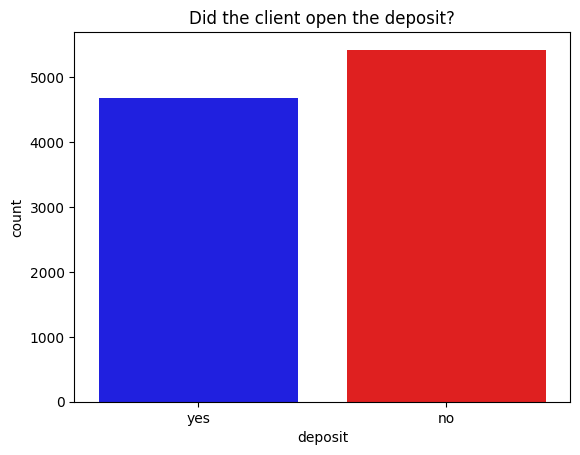

In [16]:
# изучим соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат

ax = sns.countplot(df, x=df['deposit'], palette=['b', 'r'])
ax.set_title('Did the client open the deposit?')

In [17]:
df['deposit'].value_counts(normalize=True)

deposit
no     0.536764
yes    0.463236
Name: proportion, dtype: float64

Данные немного дисбалансированы, но несильно.

### Задания 2 и 3

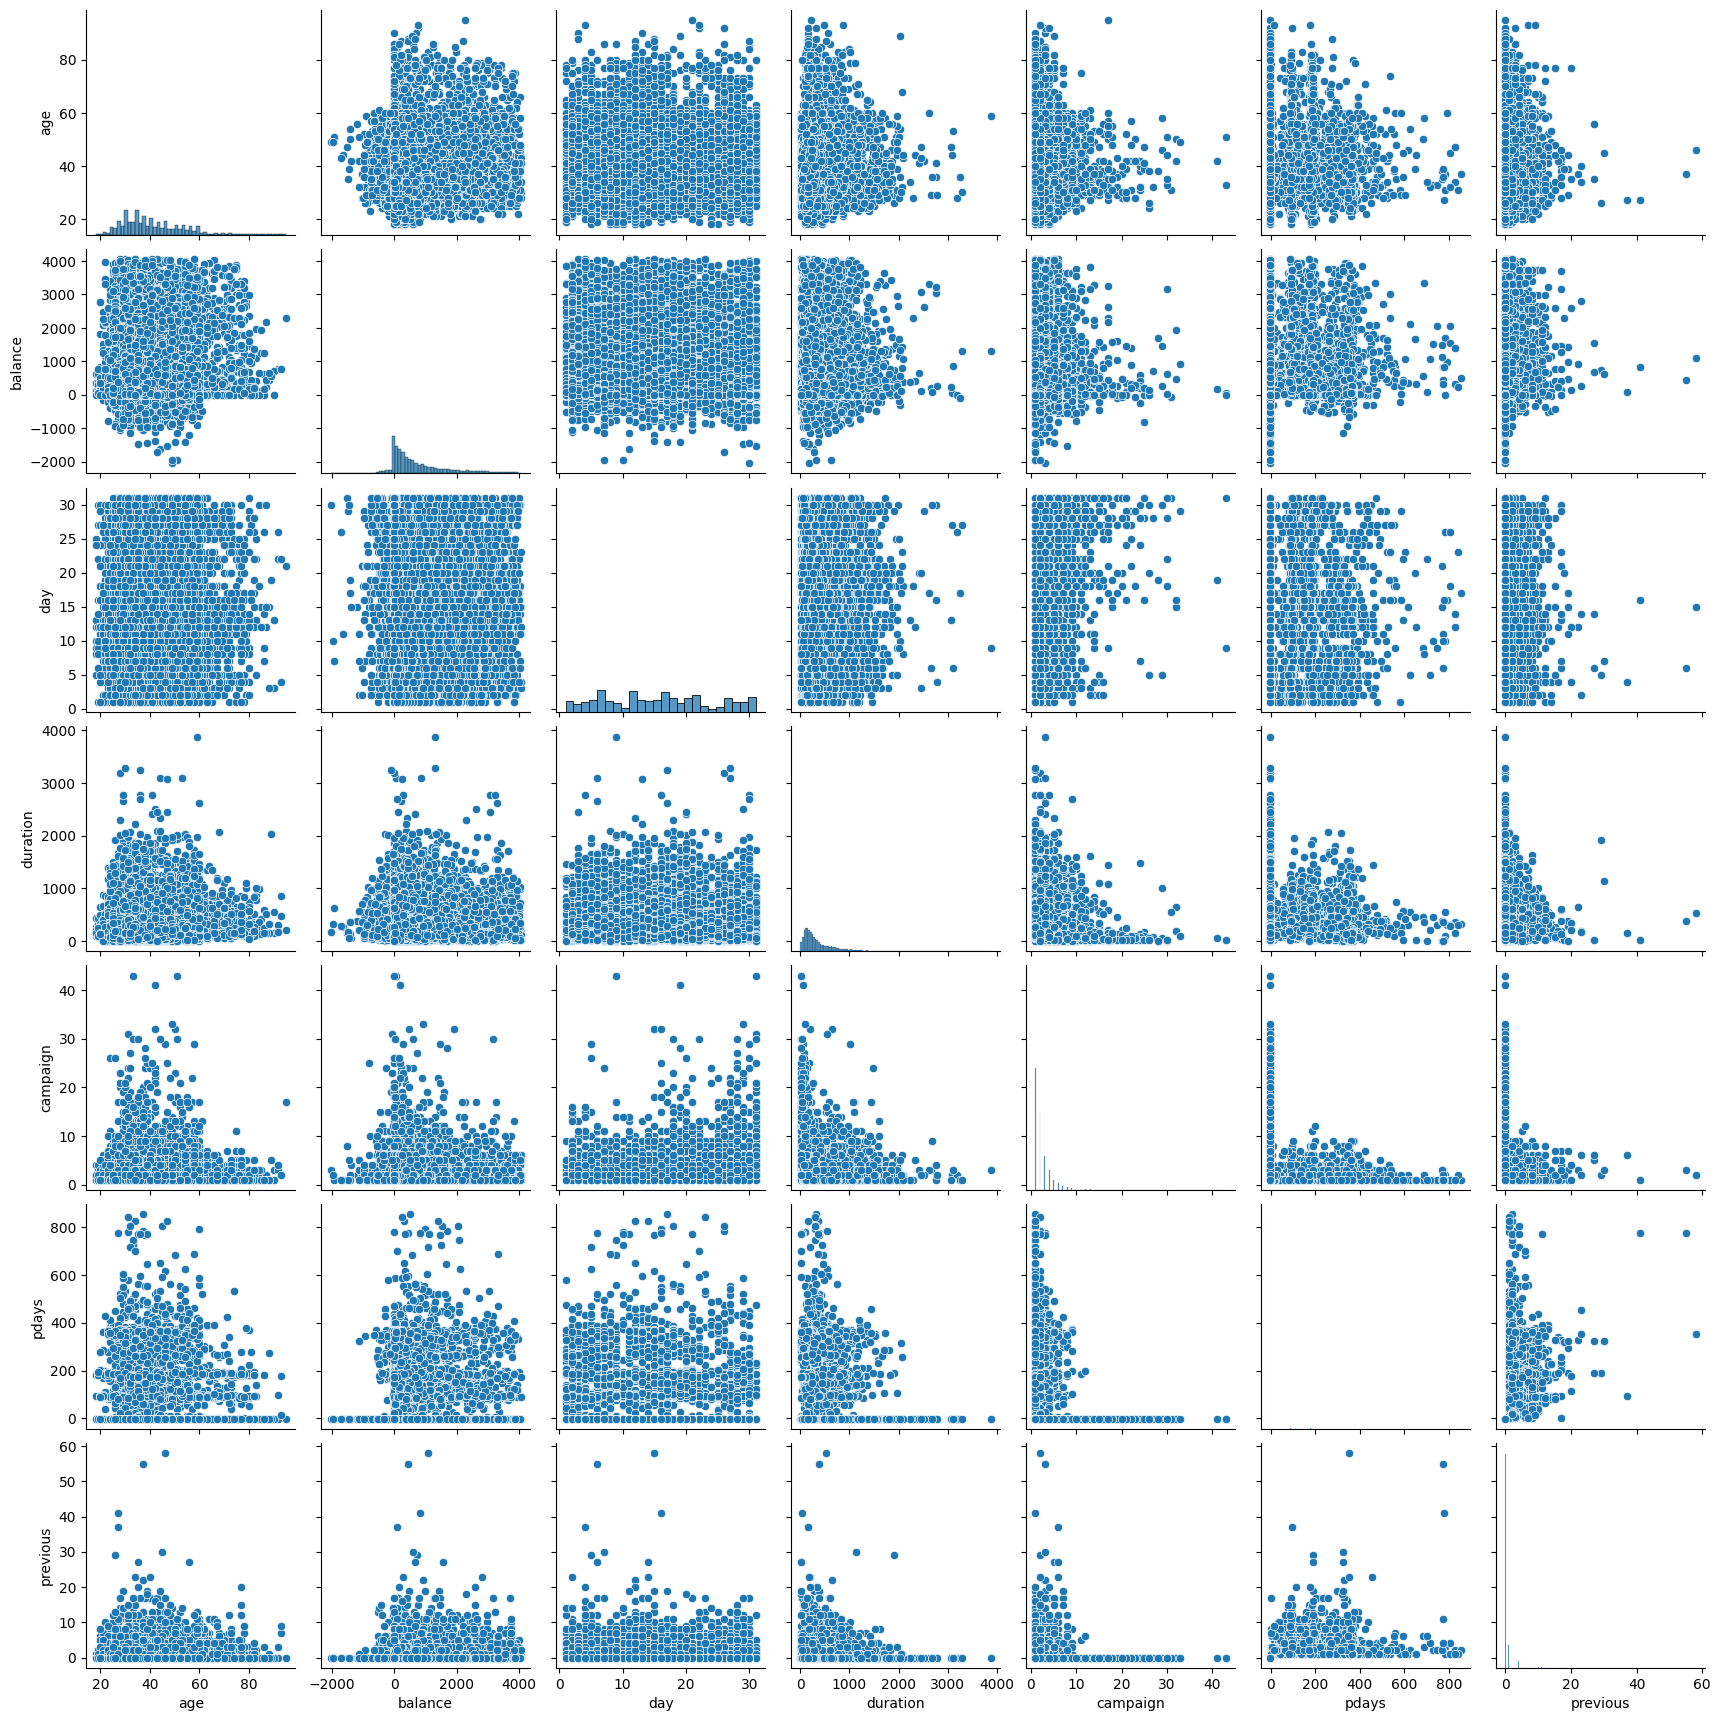

In [18]:
#рассчитаем описательные статистики для количественных переменных, проинтерпретируйте результат
sns.pairplot(df)

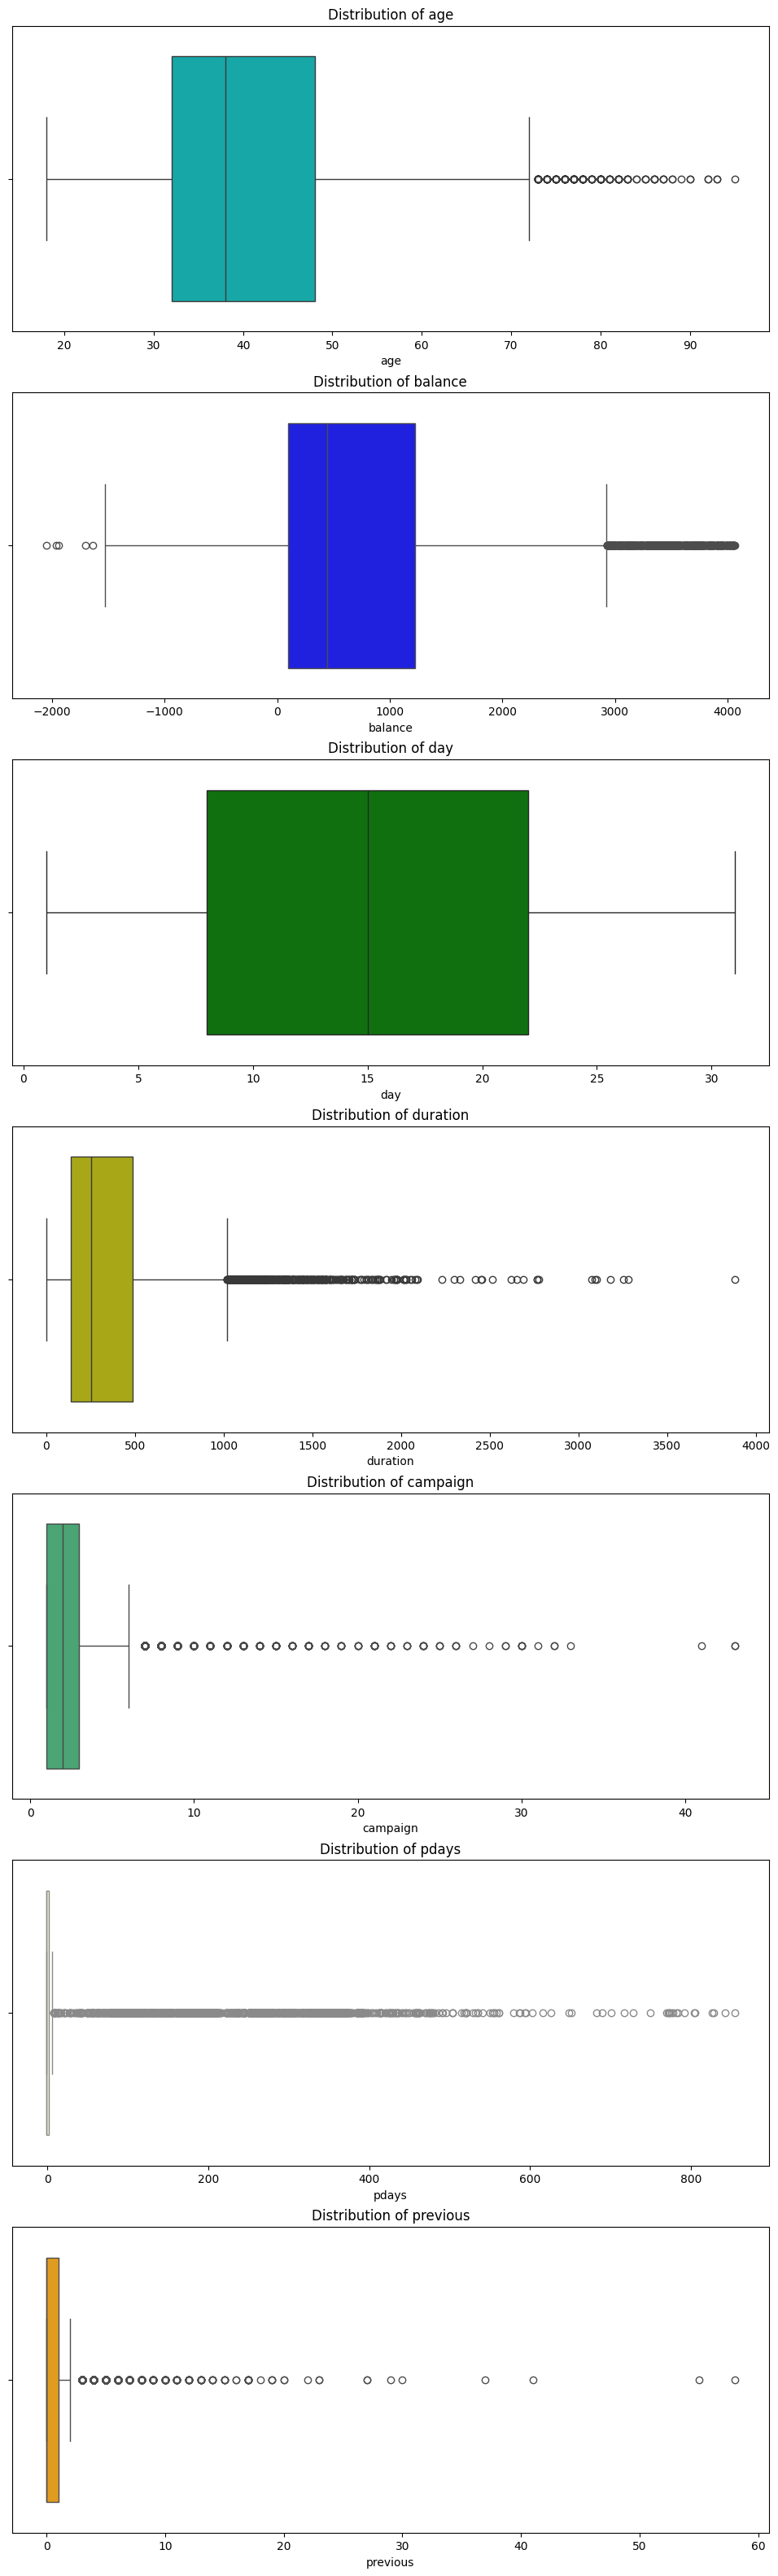

In [19]:
# найдем количественные признаки
x = df.dtypes
num_cols = []

for i in x.index:
    if x[i] != 'object':
        num_cols.append(i)
# зададим оси и цвета для коробчатых графиков 
fig, ax = plt.subplots(len(num_cols), 1, figsize=(12, 40))
color_map = ['c', 'b', 'g', 'y', 'mediumseagreen', 'lemonchiffon', 'orange']

# циклом проходимся по списку количественных переменных
for i in range(len(num_cols)):
    # название признака
    name = num_cols[i]
    # строим коробчатую диаграмму
    sns.boxplot(x=df[name], ax=ax[i], orient='h', color=color_map[i])
    ax[i].set_title('Distribution of '+name)

In [20]:
df['age'].max()

95

In [21]:
df['duration'].min()

2

<Axes: >

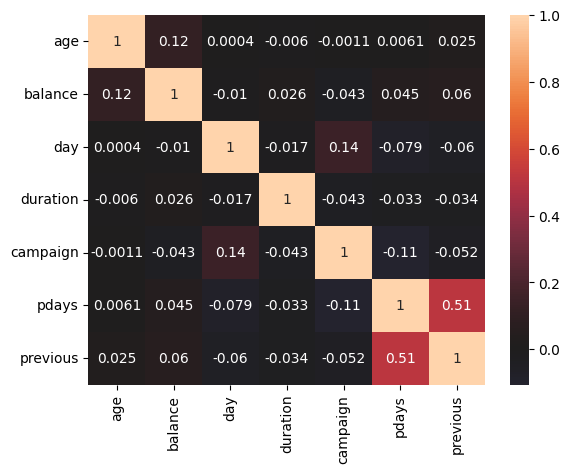

In [22]:
sns.heatmap(df.corr(numeric_only=True), annot=True, center=0)

Судя по графикам, в данных довольно много выбросов, особенно в признаках duration, campaign, pdays, previous. Признак day распределён практически равномерно, а распределение признаков balance, campaign, duration и previous похоже на логнормальное. Корреляции между количественными признаками практически нет.

### Задания 4 и 5

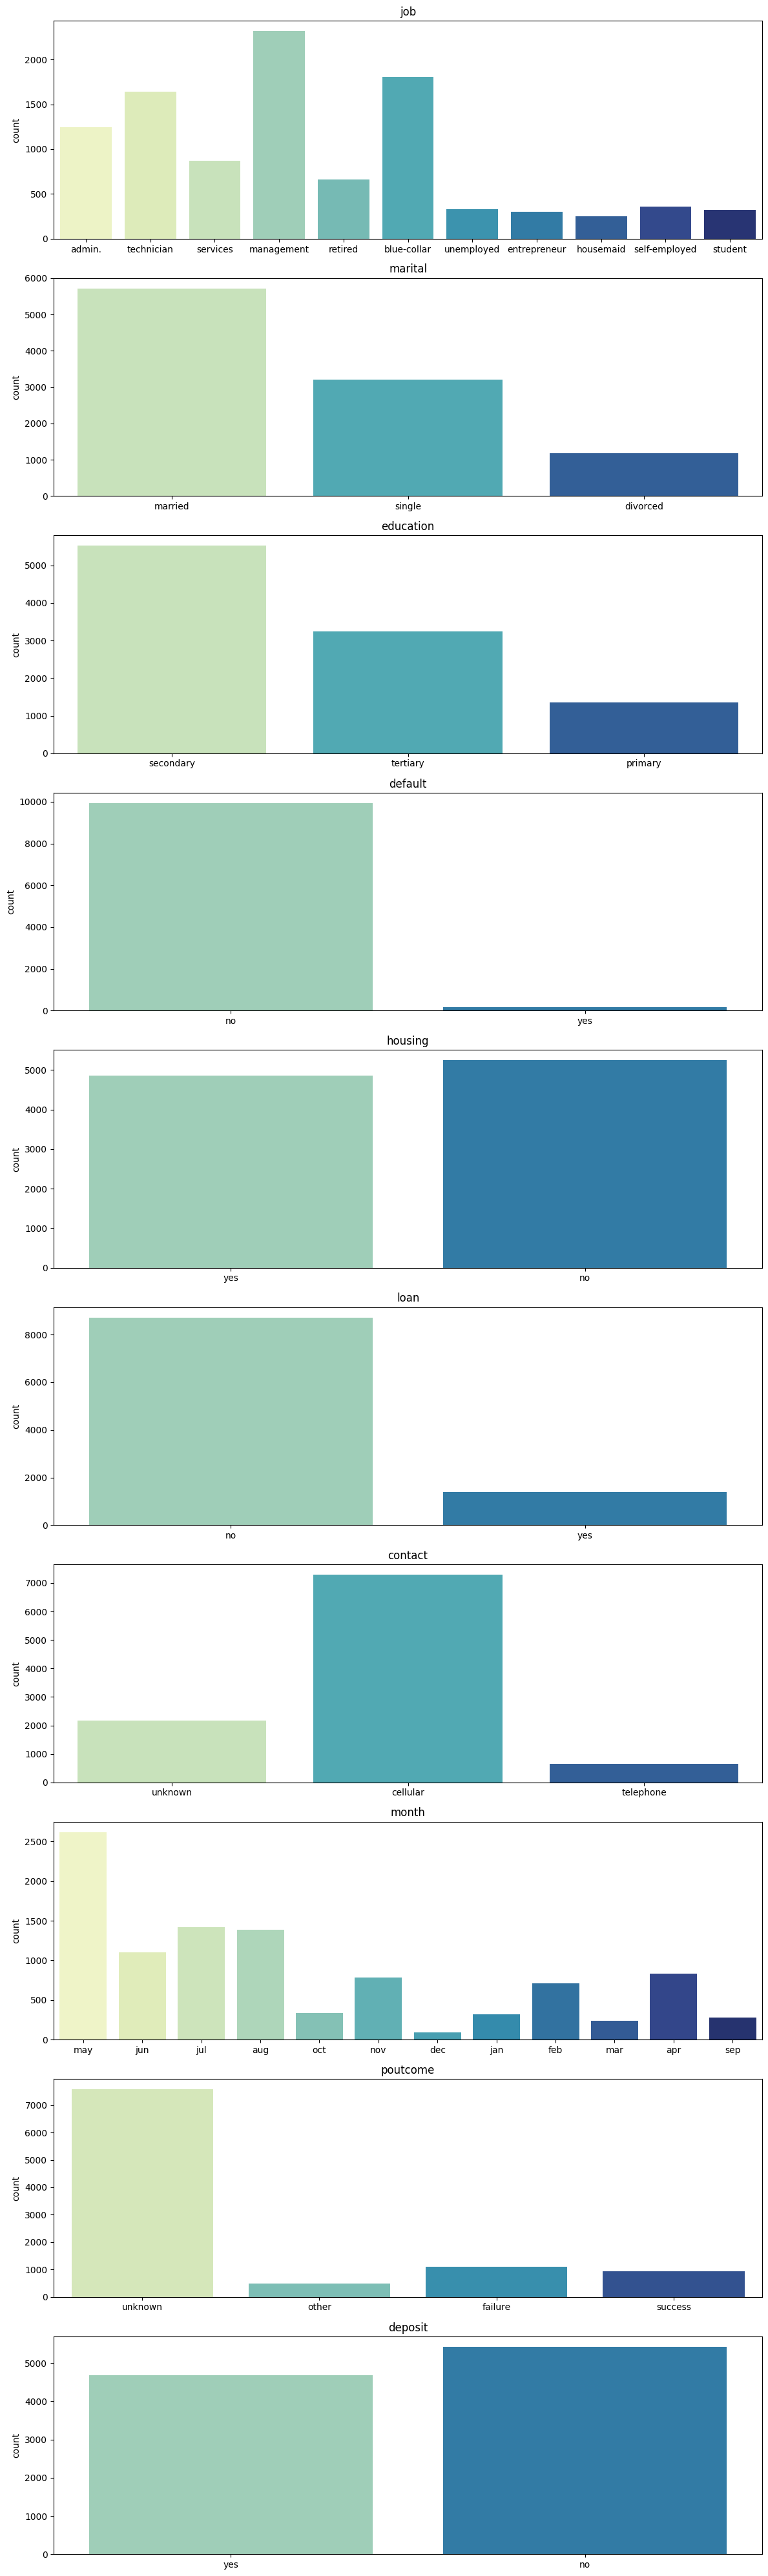

In [23]:
# теперь рассчитаем описательные статистики для категориальных переменных, проинтерпретируйте результат
x = df.dtypes
cat_cols = []

for i in x.index:
    if x[i] == 'object':
        cat_cols.append(i)

fig, ax = plt.subplots(len(cat_cols), 1, figsize=(12, 40))

for i in range(len(cat_cols)):
    sns.countplot(df, x=cat_cols[i], palette='YlGnBu', ax=ax[i])
    ax[i].set_title(cat_cols[i])
    ax[i].set_xlabel('')

plt.tight_layout()

In [24]:
df['month'].nunique()

12

In [25]:
df['job'].nunique()

11

Из графиков выясняем, что на самом деле пропуски еще есть в признаках contact и poutcome, в котором вообще практически все данные - это пропуски. Из интересного можно выделить то, что большинство наблюдений сделано в мае, чаще всего для рекламной компании использовались звонки на мобильный телефон; лишь у немногих клиентов банка есть кредит, в добавок в банке очень мало должников. Типичный клиент банка состоит в браке, имеет среднее образование и работает в менеджменте.

### Задание 6

In [26]:
# рассмотрим, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df.groupby('poutcome')['deposit'].value_counts()

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: count, dtype: int64

Иными словами, те пользователи, которые воспользовались предложением прошлой рекламной компании, с высокой долей вероятности согласятся и на следующее предложение.

### Задание 7

In [27]:
# выведем, в каком месяце чаще всего отказывались от предложения открыть депозит

df.groupby('month')['deposit'].value_counts().nlargest(1)

month  deposit
may    no         1776
Name: count, dtype: int64

or

In [28]:
pivot = df.pivot_table(
    columns=['deposit'],
    index='month',
    aggfunc='count',
)

pivot['balance']['no'].nlargest(1)

month
may    1776
Name: no, dtype: int64

### Задание 8

<Axes: xlabel='cat_age', ylabel='count'>

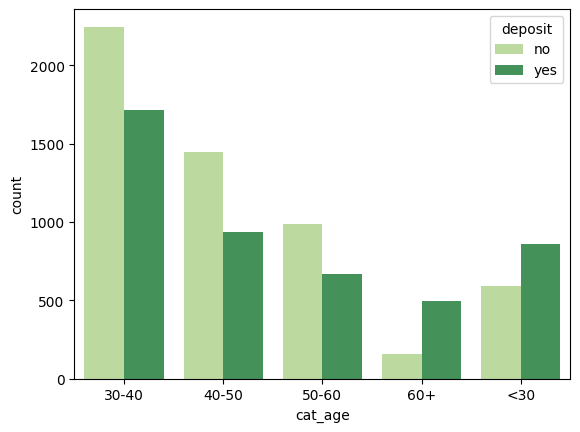

In [29]:
# создадим возрастные группы и определим, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age_categorizer(x):
    if x < 30: return '<30'
    elif x >= 30 and x < 40: return '30-40'
    elif x >= 40 and x < 50: return '40-50'
    elif x >= 50 and x < 60: return '50-60'
    else: return '60+'
    
df['cat_age'] = df['age'].apply(age_categorizer)

data = df.groupby(['cat_age', 'deposit']).size()

t = data.reset_index(name='count')
sns.barplot(data=t, x='cat_age', y='count', hue='deposit', palette='YlGn')

or

<Axes: xlabel='cat_age', ylabel='count'>

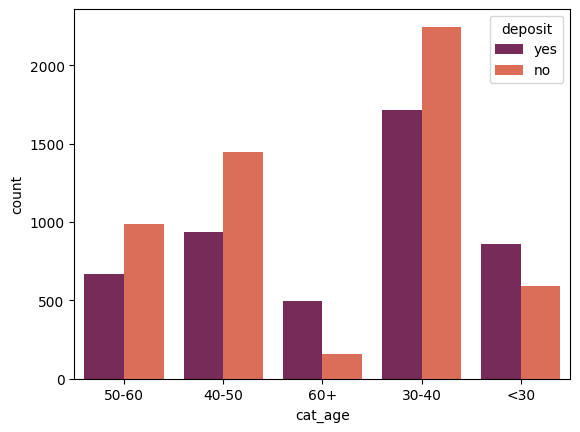

In [30]:
sns.countplot(data=df, x='cat_age', hue='deposit', palette='rocket')

In [31]:
# вместо того, чтобы писать функцию, можно было также использовать метод cut()
# библиотеки pandas
df['cat_cut_age'] = pd.cut(df['age'], bins=[0, 30, 40, 50, 60, 150], 
                           labels=['<30', '30-40', '40-50', '50-60', '60+'])
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,cat_age,cat_cut_age
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60,50-60
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60,50-60
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50,40-50
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60,50-60
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60,50-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10100,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no,30-40,30-40
10101,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no,30-40,30-40
10102,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no,30-40,30-40
10103,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no,40-50,40-50


Видим, что в возрастной группе 30-60 лет чаще всего больше отказов, а для групп <30 и >60 наоборот, причем в процентном соотношении чаще всего соглашаются пожилые люди (60+).

In [32]:
# удалим признак экспериментальный 'cat_cut_age'
df = df.drop(['cat_cut_age'], axis=1)

Признак cat_age пригодится при кодировке данных.

### Задания 9 и 10

<Axes: xlabel='marital', ylabel='count'>

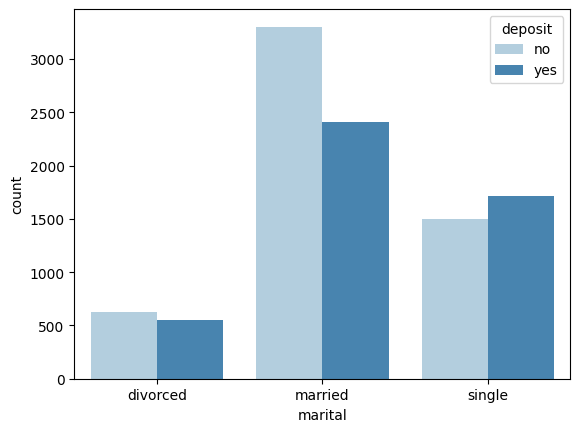

In [33]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
data_fam = df.groupby(['marital', 'deposit']).size().reset_index(name='count')

sns.barplot(data_fam, x='marital', hue='deposit', y='count', palette='Blues')

Из графика следует, что только в группе одиноких людей немного преобладает число людей, согласившихся открыть депозит в банке после рекламной компании. У разведённых людей кол-во согласившихся и отказавшихся примерно одинаково, среди женатых превалирует отказ от открытия депозита.

<Axes: xlabel='education', ylabel='count'>

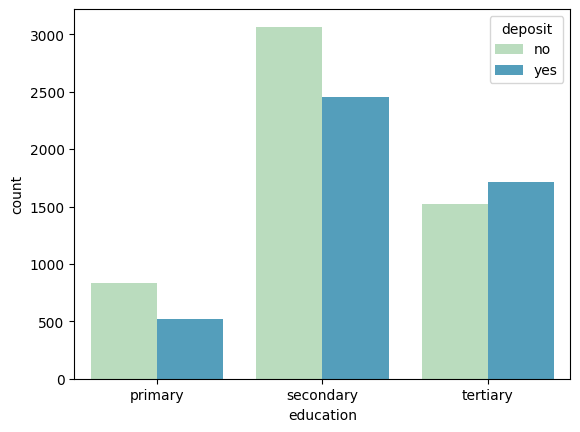

In [34]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от образования
data_edu = df.groupby(['education', 'deposit']).size().reset_index(name='count')

sns.barplot(data_edu, x='education', hue='deposit', y='count', palette='GnBu')

Как видно, среди людей со средним (неполным и полным) образованием большинство не согласились открыть депозит в банке. Среди людей с высшим образованием кол-во согласных и несогласных примерно одинаково с небольшим перевесом в сторону согласных.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'admin.'),
  Text(1, 0, 'blue-collar'),
  Text(2, 0, 'entrepreneur'),
  Text(3, 0, 'housemaid'),
  Text(4, 0, 'management'),
  Text(5, 0, 'retired'),
  Text(6, 0, 'self-employed'),
  Text(7, 0, 'services'),
  Text(8, 0, 'student'),
  Text(9, 0, 'technician'),
  Text(10, 0, 'unemployed')])

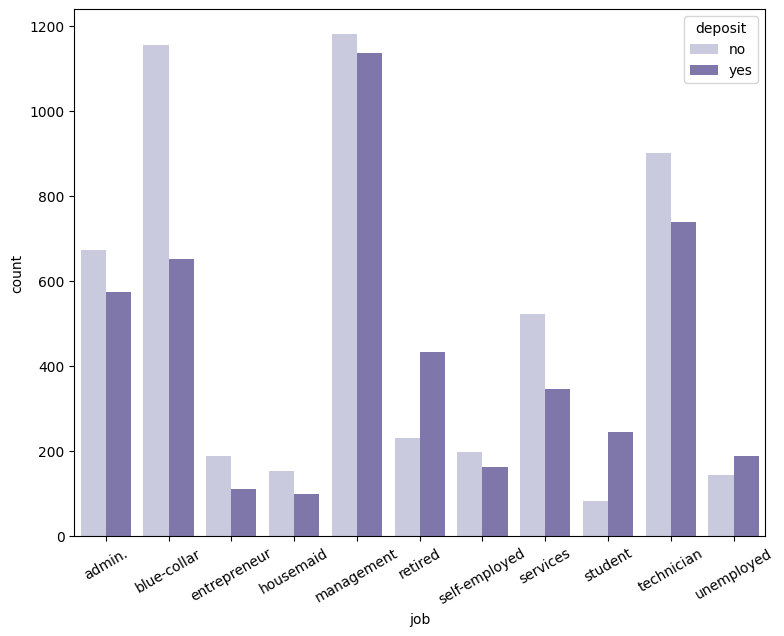

In [35]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
data_job = df.groupby(['job', 'deposit']).size().reset_index(name='count')

fig = plt.figure(figsize=(8, 6))
sns.barplot(data_job, x='job', hue='deposit', y='count', palette='Purples')
plt.tight_layout()
plt.xticks(rotation=30)

Получили довольно много информации по разным типам занятости. Если выделить самое важное, то больше соглашаются чем нет на депозит вышедшие на пенсию (retired), безработные (unemployed) и студенты (students). Однако в общем зачете больше соглашений у людей, работающих в сфере management, у инженеров (technician) и так называемых "синих воротничков" (наёмных рабочих, blue-collar). У последних, несмотря на топ-3 по согласию на депозит в целом, самый высокий процент отказов от депозита внутри группы.

### Задание 11

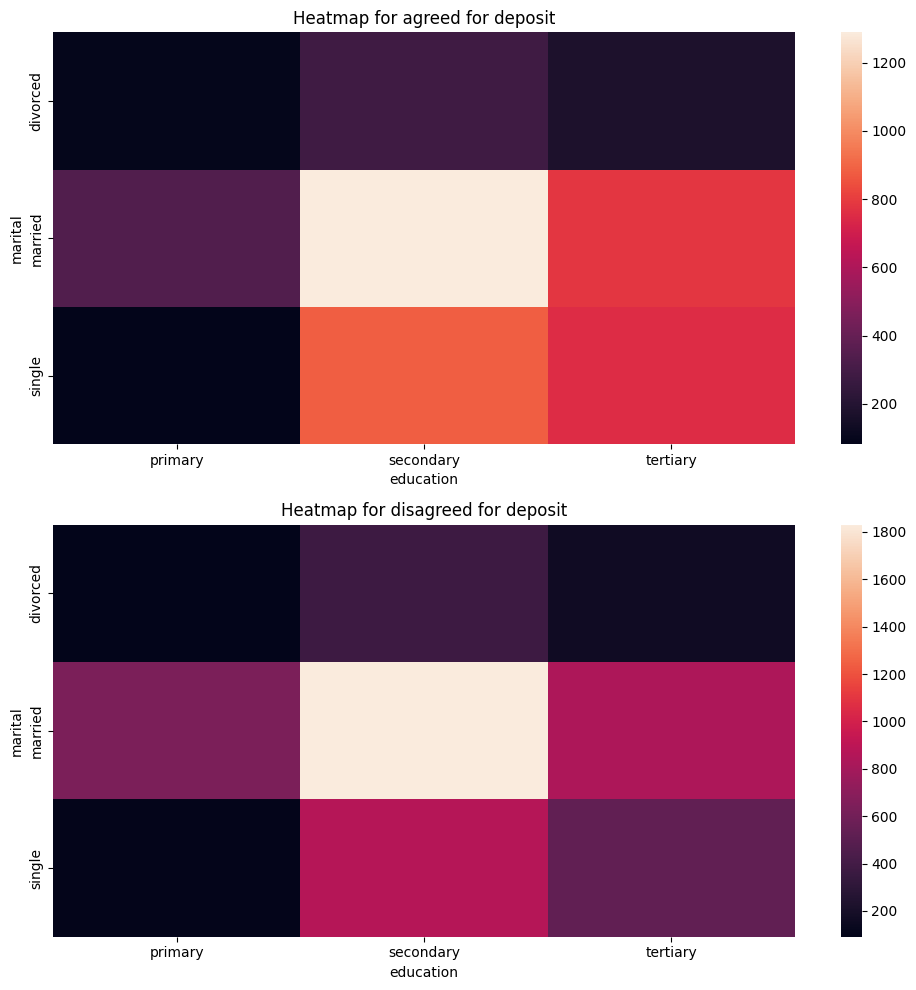

In [36]:
# построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
# разделим данные на согласившихся и отказавшихся открыть депозит
df_dep_yes = df[df['deposit']=='yes']
df_dep_no = df[df['deposit']=='no']
# построим сводные таблице для каждой группы
pivot_yes = df_dep_yes.pivot_table(
    index='marital',
    columns='education',
    aggfunc='count'
)['age']

pivot_no = df_dep_no.pivot_table(
    index='marital',
    columns='education',
    aggfunc='count'
)['age']

# визуализируем результат с помощью тепловых карт
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
# тепловая карта для согласившихся открыть депозит
sns.heatmap(pivot_yes, ax=ax[0])
ax[0].set_title('Heatmap for agreed for deposit')
# тепловая карта для отказавшихся открыть депозит
sns.heatmap(pivot_no, cmap='rocket', ax=ax[1])
ax[1].set_title('Heatmap for disagreed for deposit')
plt.tight_layout()

Можно сказать, что группы распределение групп по популярности примерно одинаково.

## Часть 3: преобразование данных

### Задание 1

In [37]:
# преобразуем уровни образования
le = LabelEncoder()

df['education'] = le.fit_transform(df['education'])
df['education']

0        1
1        1
2        1
3        1
4        2
        ..
10100    0
10101    1
10102    1
10103    1
10104    1
Name: education, Length: 10105, dtype: int32

In [38]:
df['education'].sum()

11995

In [39]:
# преобразуем признак cat_age
le = LabelEncoder()

df['cat_age'] = le.fit_transform(df['cat_age'])
df['cat_age']

0        2
1        2
2        1
3        2
4        2
        ..
10100    0
10101    0
10102    0
10103    1
10104    0
Name: cat_age, Length: 10105, dtype: int32

### Задания 2 и 3

In [40]:
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,cat_age
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,2
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1


In [41]:
# преобразуем бинарные переменные в представление из нулей и единиц
cat_bin_cols = ['default', 'housing', 'loan', 'deposit']

for i in cat_bin_cols:
    df[i] = df[i].apply(lambda x: 1 if x=='yes' else 0)

In [42]:
df['deposit'].std()

0.4986712532452124

In [43]:
round(df['default'].mean()+df['housing'].mean()+df['loan'].mean(), 3)

0.635

### Задание 4

In [44]:
pd.set_option('display.max_columns', None)

In [45]:
# создадим дамми-переменные
dummy_df = pd.get_dummies(df, dtype=int)
dummy_df

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,previous,deposit,cat_age,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,1,0,2343.0,1,0,5,1042,1,-1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,56,1,0,45.0,0,0,5,1467,1,-1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,41,1,0,1270.0,1,0,5,1389,1,-1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,55,1,0,2476.0,1,0,5,579,1,-1,0,1,2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,54,2,0,184.0,0,0,5,673,2,-1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10100,33,0,0,1.0,1,0,20,257,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10101,39,1,0,733.0,0,0,16,83,4,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
10102,32,1,0,29.0,0,0,19,156,2,-1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10103,43,1,0,0.0,0,1,8,9,2,172,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


### Задания 5 и 6

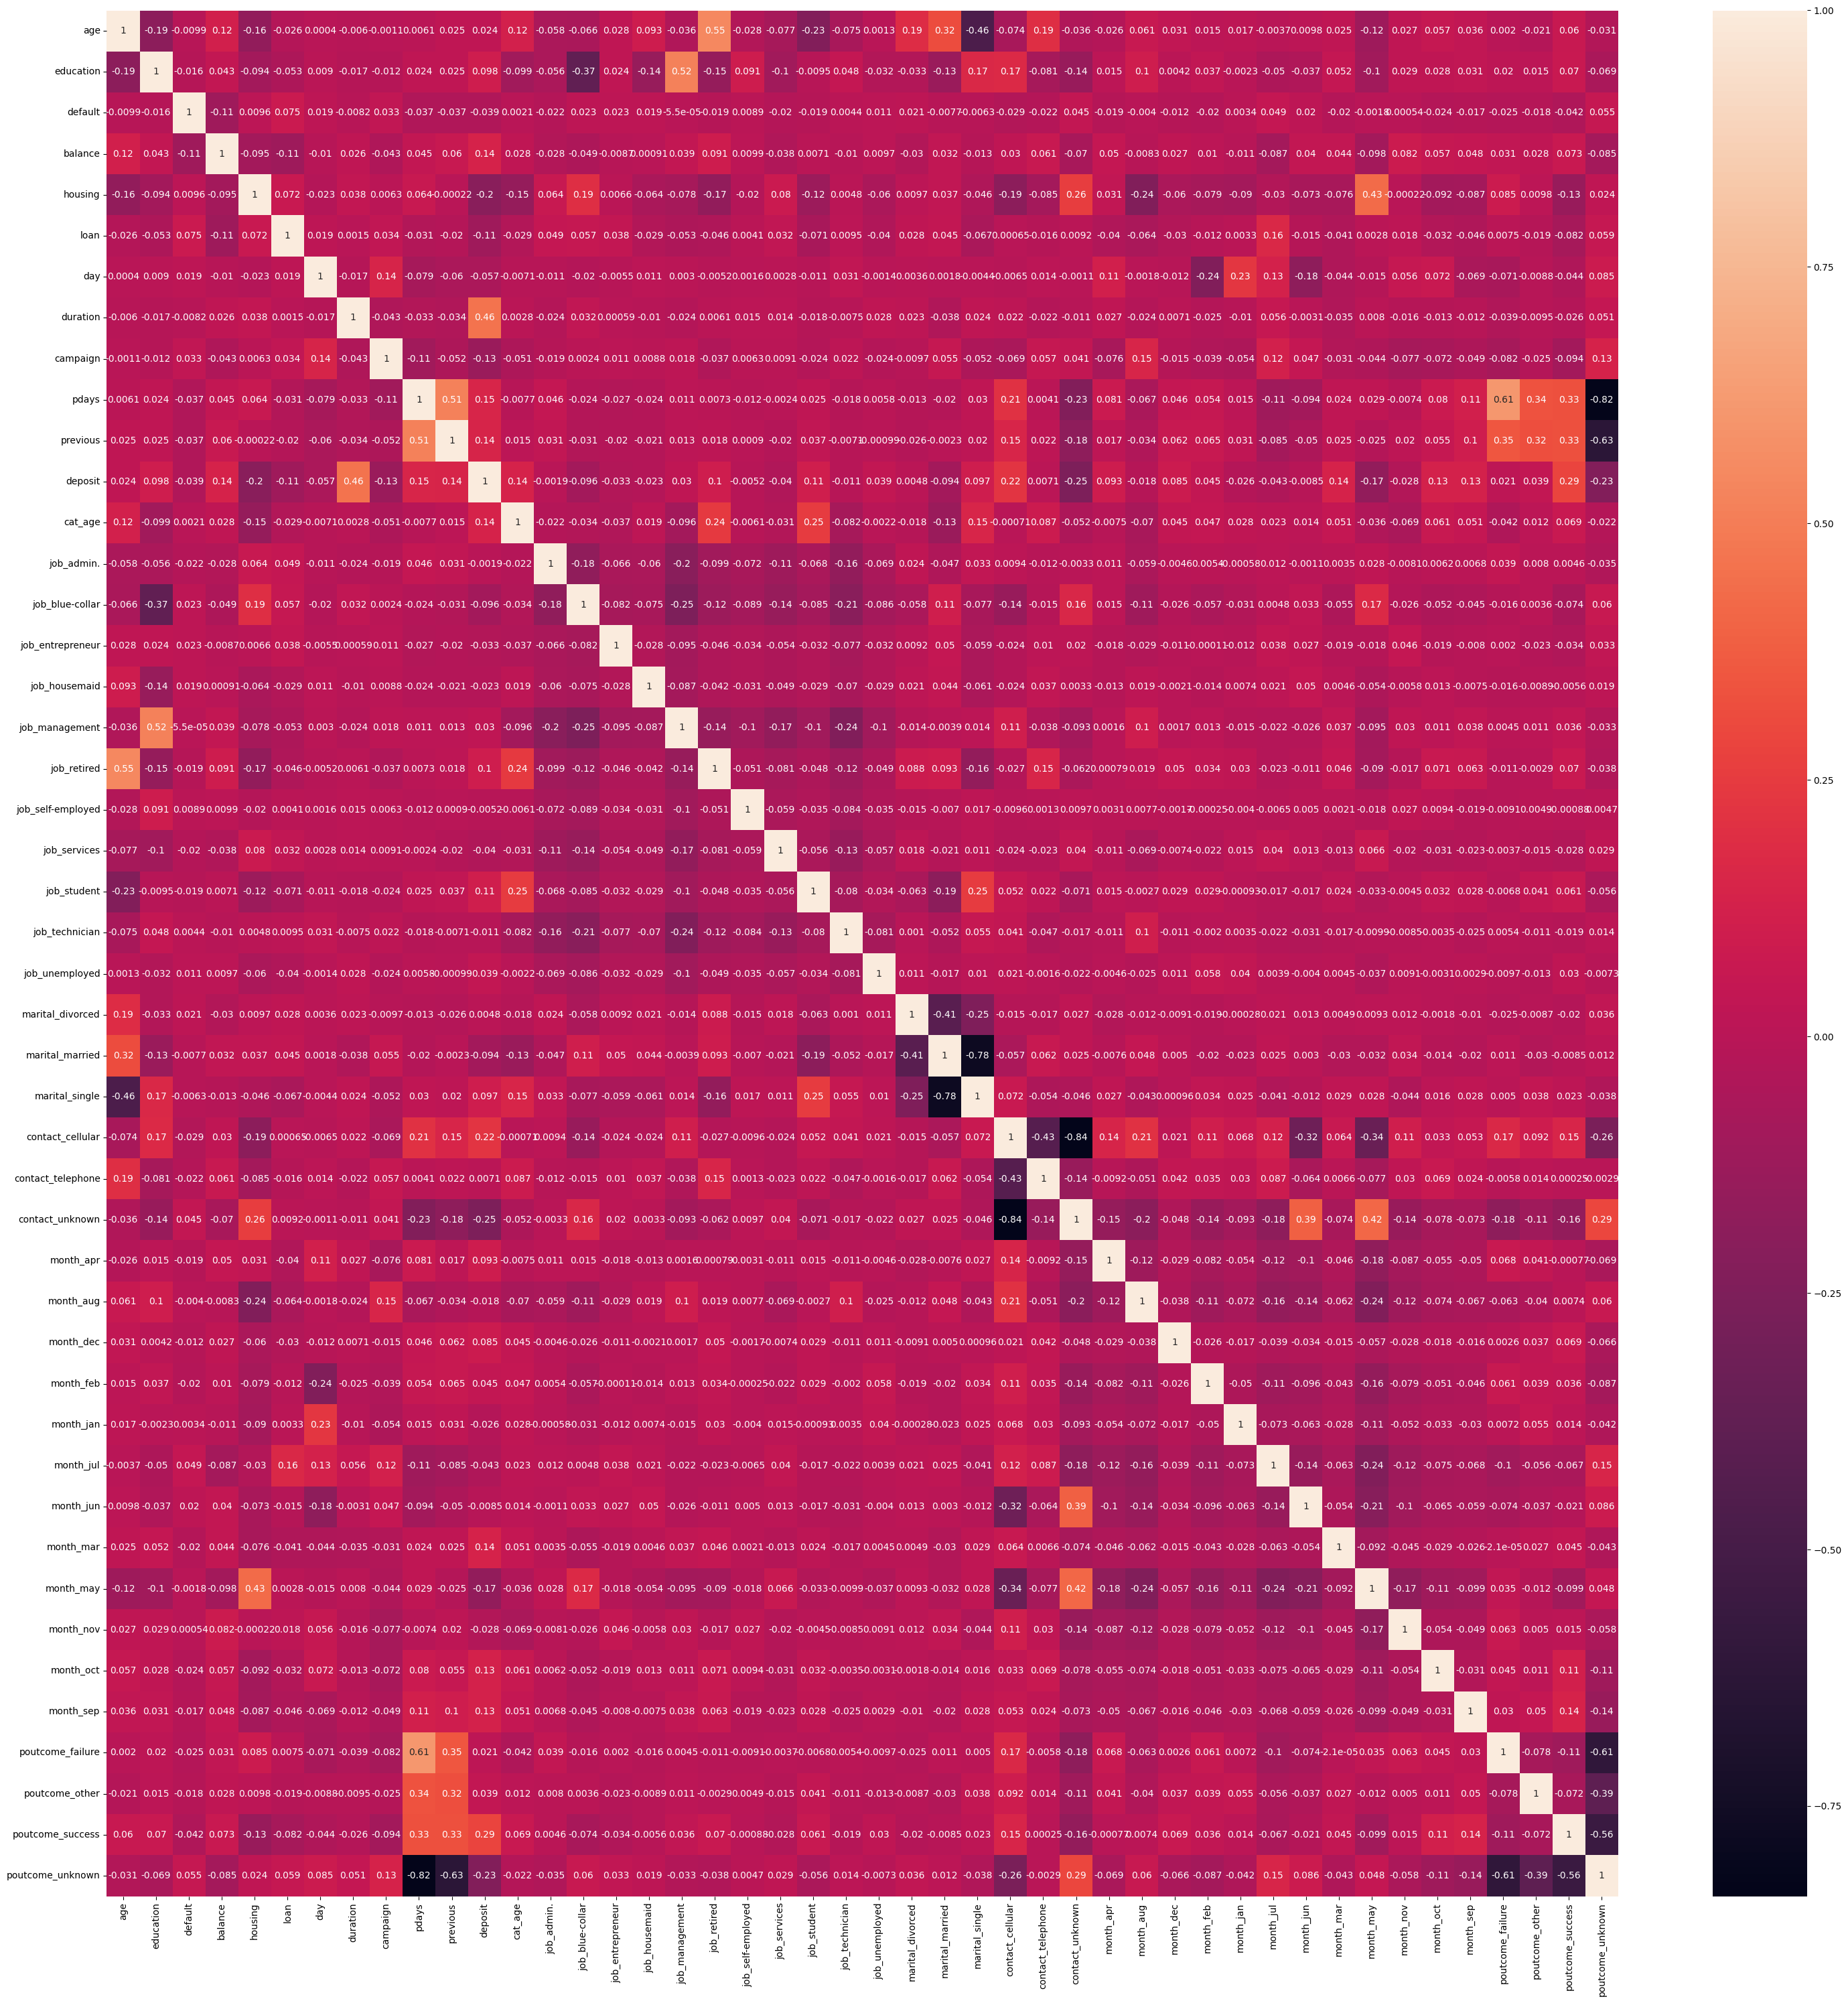

In [46]:
# построим корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(30, 30))
sns.heatmap(dummy_df.corr(), annot=True)
plt.tight_layout()

### Задания 7 и 8

Переходим к подготовке разбиению и подготовке данных для модели машинного обучения.

In [47]:
X = dummy_df.drop('deposit', axis=1)
y = dummy_df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

In [48]:
# рассчитаем необходимые показатели
print(f'Test data shape: {X_test.shape}')
print(f'Mean value for test target var: {round(y_test.mean(), 2)}')

Test data shape: (3335, 45)
Mean value for test target var: 0.46


### Задание 9

In [49]:
# с помощью SelectKBest отберём 15 наиболее подходящих признаков
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)

best_cols = list(selector.get_feature_names_out())
best_cols

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'cat_age',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

In [50]:
X_train = X_train[best_cols]
X_test = X_test[best_cols]

### Задание 10

In [51]:
# нормализуем данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [52]:
round(X_test[:, 0].mean(), 2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

Начнем с самого простого - логистической регрессии.

In [53]:
# обучим логистическую регрессию и рассчитаем метрики качества
log_reg_model = linear_model.LogisticRegression(max_iter=1000, solver='sag', random_state=42)
log_reg_model.fit(X_train, y_train)

y_pred = log_reg_model.predict(X_test)
print('Accuracy for test data: {}'.format(round(metrics.accuracy_score(y_test, y_pred), 3)))
print('\n')
print(metrics.classification_report(y_test, y_pred))

Accuracy for test data: 0.805


              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



### Задания 2,3,4

Теперь попробуем решающие деревья.

In [54]:
# обучим решающие деревья
dt_model = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_model.fit(X_train, y_train)

y_train_pred = dt_model.predict(X_train)
y_test_pred = dt_model.predict(X_test)

print('Classification report for train data: \n \n{}'.format(metrics.classification_report(y_train, y_train_pred)))
print('\n')
print('Classification report for test data: \n \n{}'.format(metrics.classification_report(y_test, y_test_pred)))

Classification report for train data: 
 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770



Classification report for test data: 
 
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1790
           1       0.74      0.71      0.72      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.74      0.75      3335
weighted avg       0.75      0.75      0.75      3335



Как видим, не задавая макс. глубину дерева, мы переобучаем модель.

### Задание 5

In [55]:
np.arange(5, 160, 10)

array([  5,  15,  25,  35,  45,  55,  65,  75,  85,  95, 105, 115, 125,
       135, 145, 155])

In [56]:
# подберём оптимальные параметры с помощью gridsearch
params = {'min_samples_split': [2, 5, 7, 10],
            'max_depth':[3,5,7]}

grid_searcher = GridSearchCV(estimator=dt_model, param_grid=params, n_jobs=-1)
grid_searcher.fit(X_train, y_train)

dt_best_model = grid_searcher.best_estimator_

In [57]:
dt_best_model

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=10,
                       random_state=42)

In [58]:
print(f'Classification report for test data: \n \n{metrics.classification_report(y_test, dt_best_model.predict(X_test))}')

Classification report for test data: 
 
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.79      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Благодаря подбору параметров, особенно определению глубины дерева, удалось избавиться от переобучения и увеличить показатели на тестовой выборке.

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [59]:
# обучите на ваших данных случайный лес
rnd_forest_model = ensemble.RandomForestClassifier(n_estimators=100,
                                                   criterion='gini',
                                                   min_samples_leaf=5,
                                                   max_depth=10,
                                                   random_state=42)

rnd_forest_model.fit(X_train, y_train)

print(metrics.classification_report(y_test, rnd_forest_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Алгоритм случайного леса помог немного улучшить метрики.

### Задания 2 и 3

In [60]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gr_boosting_tree_clf = ensemble.GradientBoostingClassifier(
    n_estimators=300,
    max_depth=5,
    min_samples_leaf=5,
    learning_rate=0.05,
    random_state=42
)

gr_boosting_tree_clf.fit(X_train, y_train)

print(metrics.classification_report(y_test, gr_boosting_tree_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Как видно, оба ансамблиевых алгоритма одинаково хорошо справляются с задачей.

### Задание 4

In [87]:
# объединим уже известные нам алгоритмы с помощью стекинга 
final_model = ensemble.StackingClassifier(
    estimators=[('LogRegModel', log_reg_model), ('DecisionTreeModel', dt_model), ('GB_Model', gr_boosting_tree_clf)],
    final_estimator=linear_model.LogisticRegression(max_iter=1000, random_state=42)
)

final_model.fit(X_train, y_train)
print(metrics.classification_report(y_test, final_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

In [88]:
# сдалем оценку того, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
# найдем векторы значимости и преобразуем в Series
features = pd.Series(gr_boosting_tree_clf.feature_importances_)
# преобразуем наименования признаков в Series
cols = pd.Series(best_cols)
# склеим  и отсортируем списки, чтобы посмотреть на значимости признаков
t = pd.concat([cols, features], axis=1).rename(columns={0: 'feature', 1: 'importance'})
t.sort_values(by='importance', ascending=False)

,feature,importance
2,duration,0.501987
13,poutcome_success,0.116264
8,contact_unknown,0.073760
0,balance,0.059764
4,pdays,0.055702
1,housing,0.046583
6,cat_age,0.042102
9,month_mar,0.026144
11,month_oct,0.018824
3,campaign,0.017101


Как видим, самый значительный вклад в предсказание целевой переменной deposit вносит признак продолжительности контактов (duration).

### Задания 6,7,8

В задании № 5 из части 4 мы пробовали подобрать гиперпараметры для дерева решений с помощью GridSearch, однако, в части 5 мы выяснили, что ансамблиевая модель случайного леса показывает лучшую метрику. Попробуем обучить её, а гиперпараметры подобрать с помощью продвинутой библтотеки Optuna.

In [97]:
# оптимизация гиперпараметров с помощью Optuna
import optuna
# метод Optuna заключается в последовательном поиске гиперпараметров для максимизации н-которой функции.
# в нашем случае функция - это метрика f1
def optuna_f1_func(trial):
    # создаём пространство гиперпараметров
    params_space = {'n_estimators': trial.suggest_int('n_estimators', 100, 200, 1),
                    'max_depth': trial.suggest_int('max_depth', 10, 30, 1),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10, 1)}
    
    model = ensemble.RandomForestClassifier(**params_space, random_state=42)
    model.fit(X_train, y_train)
    
    score = metrics.f1_score(y_test, model.predict(X_test))
    return score
# создаём объект исследования
study = optuna.create_study(study_name='RandomForestClassifierF1', direction='maximize')
# оптимизируем функцию
study.optimize(optuna_f1_func, n_trials=35)

[I 2024-08-16 00:40:56,657] A new study created in memory with name: RandomForestClassifierF1
[I 2024-08-16 00:40:57,641] Trial 0 finished with value: 0.8182965299684543 and parameters: {'n_estimators': 198, 'max_depth': 25, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8182965299684543.
[I 2024-08-16 00:40:58,118] Trial 1 finished with value: 0.8167406467977172 and parameters: {'n_estimators': 102, 'max_depth': 13, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8182965299684543.
[I 2024-08-16 00:40:58,991] Trial 2 finished with value: 0.8176968936303733 and parameters: {'n_estimators': 153, 'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8182965299684543.
[I 2024-08-16 00:40:59,745] Trial 3 finished with value: 0.819496855345912 and parameters: {'n_estimators': 160, 'max_depth': 28, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.819496855345912.
[I 2024-08-16 00:41:00,658] Trial 4 finished with value: 0.814181703070592 and parameters: {'n_e

In [98]:
optuna.visualization.plot_optimization_history(study, target_name='f1-score')

In [99]:
study.best_params

{'n_estimators': 178, 'max_depth': 15, 'min_samples_leaf': 3}

---

In [100]:
# дополнительно проведём исследование для метрики accuracy
def optuna_acc_func(trial):
    # создаём пространство гиперпараметров
    params_space = {'n_estimators': trial.suggest_int('n_estimators', 100, 200, 1),
                    'max_depth': trial.suggest_int('max_depth', 10, 30, 1),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10, 1)}
    
    model = ensemble.RandomForestClassifier(**params_space, random_state=42)
    model.fit(X_train, y_train)
    
    score = metrics.accuracy_score(y_test, model.predict(X_test))
    return score
# создаём объект исследования
study_acc = optuna.create_study(study_name='RandomForestClassifierAccuracy', direction='maximize')
# оптимизируем функцию
study_acc.optimize(optuna_acc_func, n_trials=35)

[I 2024-08-16 00:41:27,058] A new study created in memory with name: RandomForestClassifierAccuracy
[I 2024-08-16 00:41:27,508] Trial 0 finished with value: 0.824287856071964 and parameters: {'n_estimators': 102, 'max_depth': 26, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.824287856071964.
[I 2024-08-16 00:41:28,125] Trial 1 finished with value: 0.8269865067466267 and parameters: {'n_estimators': 126, 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8269865067466267.
[I 2024-08-16 00:41:28,608] Trial 2 finished with value: 0.8305847076461769 and parameters: {'n_estimators': 101, 'max_depth': 14, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8305847076461769.
[I 2024-08-16 00:41:29,158] Trial 3 finished with value: 0.8251874062968516 and parameters: {'n_estimators': 123, 'max_depth': 14, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8305847076461769.
[I 2024-08-16 00:41:29,958] Trial 4 finished with value: 0.8266866566716642 and parameters

In [101]:
optuna.visualization.plot_optimization_history(study_acc, target_name='accuracy')

In [102]:
study_acc.best_params

{'n_estimators': 101, 'max_depth': 14, 'min_samples_leaf': 3}